# Capstone Project - Pennsylvania Movie Theatres

### Import all required libraries

In [1]:
import pandas as pd
import numpy as np
!conda install -c conda-forge geopy --yes  
from geopy.geocoders import Nominatim  
import json 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
!conda install -c conda-forge folium=0.5.0
import folium
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Prepare the credentials to access FourSquare location data

In [2]:
CLIENT_ID = 'M51GODGBQZ5SY1YM5IPZZ5TCWQGEAH3EANRQDC0HELVGQTDR' 
CLIENT_SECRET = 'O1KJUWVUBN1E4RY4TRN2BT2YLJJWKJTRCE0Q13B20TZJ4SKK' 
VERSION = '20190831'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M51GODGBQZ5SY1YM5IPZZ5TCWQGEAH3EANRQDC0HELVGQTDR
CLIENT_SECRET:O1KJUWVUBN1E4RY4TRN2BT2YLJJWKJTRCE0Q13B20TZJ4SKK


#### Read Data - Pennsylvania zipcodes/cities by percentage of Indian population - Top 100 results (1st Page)

In [36]:
pa_cities_indian = pd.read_html('https://zipatlas.com/us/pa/zip-code-comparison/percentage-indian-population.htm',header=None)[10].iloc[1:]
# Add columns to the Dataframe
pa_cities_indian.columns=['index','zipcode','location','place','population','percentage_of_indians','rank']
pa_cities_indian.head()

,index,zipcode,location,place,population,percentage_of_indians,rank
1,1.,18936,"40.220190, -75.229147","Montgomeryville, Pennsylvania",5,80.00 %,#1
2,2.,19116,"40.115569, -75.013276","Philadelphia, Pennsylvania",32560,5.93 %,#93
3,3.,15776,"41.010988, -79.111592","Sprankle Mills, Pennsylvania",58,5.17 %,#125
4,4.,15220,"40.418327, -80.050036","Pittsburgh, Pennsylvania",19693,5.08 %,#136
5,5.,19082,"39.960387, -75.270374","Upper Darby, Pennsylvania",38348,4.84 %,#146


#### Preprocess the Data

In [4]:
# Split the City & State from Place and add them as seperate columns
city_state=pa_cities_indian['place'].str.split(',', expand = True)
pa_cities_indian["city"]=city_state[0]
# Drop the columns index, location and rank
pa_cities_indian.drop(columns=['index','location','rank'],inplace=True)
# Remove % from the column
pa_cities_indian=pa_cities_indian.replace(to_replace='%',value='',regex=True)
# Replace State with PA
pa_cities_indian=pa_cities_indian.replace(to_replace='Pennsylvania',value='PA',regex=True)
# Convert the columns 'population' and 'percentage of indians' to int and float
pa_cities_indian=pa_cities_indian.astype({'population':int,'percentage_of_indians':float})
# Calculate 'Indian score'  
pa_cities_indian['indian_score']=pa_cities_indian['population']*pa_cities_indian['percentage_of_indians']/100
# Drop rows with population less than 10,000
indexNames = pa_cities_indian[pa_cities_indian['population'] < 10000].index 
pa_cities_indian.drop(indexNames, inplace=True)
# Reset index
pa_cities_indian.reset_index(drop=True)
pa_cities_indian.head(5)

,zipcode,place,population,percentage_of_indians,city,indian_score
2,19116,"Philadelphia, PA",32560,5.93,Philadelphia,1930.8080
4,15220,"Pittsburgh, PA",19693,5.08,Pittsburgh,1000.4044
5,19082,"Upper Darby, PA",38348,4.84,Upper Darby,1856.0432
6,19440,"Hatfield, PA",18043,4.81,Hatfield,867.8683
7,19020,"Bensalem, PA",53564,4.45,Bensalem,2383.5980


#### Initialize the parameters to access foursquare data. This was an iterative exercise by changing the parameters limit, radius, intent, latitude longitude accurary (llAcc) and examining the results fetched. Below are the optimal parameters used to perform a 'get ' - 'search' using Foursquare end points 

In [5]:
limit=10
radius1=10000
intent='checkin'
llAcc=10000
# Category id for 'Movie Theatre'
categoryid='4bf58dd8d48988d17f941735'

#### Define function to access location data using city and place as input parameters

In [6]:
def getNearbyVenues(names, near, radius=500):

    venues_list=[]
    
    for name, near in zip(names, near):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&radius={}&categoryId={}&intent={}&llAcc={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        near,
        radius1, 
        categoryid,
        intent,
        llAcc,
        limit)
         
        # make the GET rquest
        results = requests.get(url).json()["response"]["venues"]
        
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,  
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories'][0]['name'],
            v['location']['formattedAddress']
            )
             for v in results])
      

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'city', 
                  'Venue name',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',          
                  'Venue address'
                  ]

    return(nearby_venues)

#### Get the Movie theatre venues near by the place 

In [7]:
pa_movie_theatre_venues_backup = getNearbyVenues(names=pa_cities_indian['city'],
                                   near=pa_cities_indian['place']
                                  )

pa_movie_theatre_venues_backup.shape

Philadelphia
Pittsburgh
Upper Darby
Hatfield
Bensalem
King Of Prussia
Philadelphia
Philadelphia
Pittsburgh
Philadelphia
Pittsburgh
Monroeville
Lansdale
North Wales
Bristol
Pittsburgh
Pittsburgh
Philadelphia
Philadelphia
Clifton Heights
Philadelphia
Exton
State College
Blue Bell
Scranton
Norristown
Horsham
Bryn Mawr
Pittsburgh
State College
Whitehall
Murrysville
Wexford
Harrisburg
Morrisville
Fairless Hills
Newtown
Malvern
Philadelphia
Philadelphia
Hershey
West Chester
Allentown
Norristown
Broomall
Wayne
Reading
Bethlehem
Conshohocken
Philadelphia
Macungie
Allentown
Harleysville
Plymouth Meeting
Easton
Camp Hill
Philadelphia
Downingtown
Mechanicsburg
Bridgeville
Glenshaw
Warminster
Pittsburgh
Reading
Levittown


(625, 6)

In [8]:
#  DO NOT DELETE THIS CELL - Take a copy of the Foursquare data as there is a limit for 950 API calls for regular account. 
pa_movie_theatre_venues = pa_movie_theatre_venues_backup.copy()


In [ ]:
print(pa_movie_theatre_venues.loc[pa_movie_theatre_venues['city'] == 'Scranton'])

In [10]:
# Remove The theatre venues which are not Multiplex or Movie Theatre
indexNames = pa_movie_theatre_venues[(pa_movie_theatre_venues['Venue Category'] != 'Multiplex') & (pa_movie_theatre_venues['Venue Category'] != 'Movie Theater')].index 
pa_movie_theatre_venues.drop(indexNames, inplace=True)



### Visualize the Movie Theatres data using Folium Map to check if venues are scattered across Pennsylvania

In [11]:
# create map of Pennsylvania using latitude and longitude values
latitude = 39.9526
longitude = -75.1652
map_pa_theaters = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, label in zip(pa_movie_theatre_venues['Venue Latitude'], pa_movie_theatre_venues['Venue Longitude'], pa_movie_theatre_venues['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pa_theaters)  
    
map_pa_theaters

In [12]:
# Drop venue Latitude & Longitude as we dont need them for clustering analysis.
# Drop the venue name and venue category columns after removing the duplicates from Venue name
pa_movie_theatre_venues.drop(columns=['Venue Latitude','Venue Longitude'],inplace=True)
pa_movie_theatre_venues.drop_duplicates(['Venue name'],inplace=True)
pa_movie_theatre_venues.drop(columns=['Venue name','Venue Category'],inplace=True)
pa_movie_theatre_venues.shape

(173, 2)

In [14]:
# Group the city and get the sum of theatre counts
pa_movie_theatres=pa_movie_theatre_venues.groupby(["city"])["city"].count()
pa_movie_theatres=pa_movie_theatres.to_frame()
pa_movie_theatres.columns={'Theatre Counts'}
pa_movie_theatres.reset_index(inplace=True)

In [15]:
pa_movie_theatres.head()

,city,Theatre Counts
0,Allentown,3
1,Bensalem,9
2,Blue Bell,2
3,Bridgeville,2
4,Bristol,2


In [16]:
# From our cities/indian population dataframe, drop the unwanted columns and retain only City and Indian score fields. calculate total indian score by City
pa_cities_indian_new=pa_cities_indian.drop(columns=['population','zipcode','place','percentage_of_indians'])
pa_cities_indian_new = pa_cities_indian_new.groupby('city').sum().reset_index()
pa_cities_indian_new

,city,percentage_of_indians
0,Allentown,1.95
1,Bensalem,4.45
2,Bethlehem,0.97
3,Blue Bell,1.68
4,Bridgeville,0.83
5,Bristol,2.21
6,Broomall,1.03
7,Bryn Mawr,1.56
8,Camp Hill,0.89
9,Clifton Heights,1.92


In [99]:
# Merge the 2 dataframes to get the City, Theatre Counts and Indian scores

In [17]:
pa_movie_scaled=pd.merge(pa_movie_theatres,pa_cities_indian_new,on='city',how='left',suffixes=('','_y'))

In [18]:
pa_movie_scaled

,city,Theatre Counts,percentage_of_indians
0,Allentown,3,1.95
1,Bensalem,9,4.45
2,Blue Bell,2,1.68
3,Bridgeville,2,0.83
4,Bristol,2,2.21
5,Broomall,4,1.03
6,Bryn Mawr,7,1.56
7,Clifton Heights,3,1.92
8,Downingtown,1,0.86
9,Easton,6,0.89


#### Use Min Max Scaler to scale the values of Theatre counts and Indian Score across the dataframe. This is to get optimum results in the K means clustering 

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [20]:
pa_movie_scaled[['Theatre Counts','percentage_of_indians']] = scaler.fit_transform(pa_movie_scaled[['Theatre Counts','percentage_of_indians']])
pa_movie_scaled

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,city,Theatre Counts,percentage_of_indians
0,Allentown,0.250,0.045276
1,Bensalem,1.000,0.143701
2,Blue Bell,0.125,0.034646
3,Bridgeville,0.125,0.001181
4,Bristol,0.125,0.055512
5,Broomall,0.375,0.009055
6,Bryn Mawr,0.750,0.029921
7,Clifton Heights,0.250,0.044094
8,Downingtown,0.000,0.002362
9,Easton,0.625,0.003543


In [21]:
pa_movie_cluster = pa_movie_scaled.drop('city',1)

In [22]:
pa_movie_cluster.head()

,Theatre Counts,percentage_of_indians
0,0.250,0.045276
1,1.000,0.143701
2,0.125,0.034646
3,0.125,0.001181
4,0.125,0.055512


#### K MEANS CLUSTERING 

##### We will run the K means algorith with number of clusters as 4 ... to start with

In [38]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pa_movie_cluster)
kmeans.labels_[:] 

array([1, 0, 1, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 1,
       3, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 3, 1, 1, 1, 0, 3], dtype=int32)

##### 1) Now Iterate the clustering model with number of clusters starting from 1 to 10. 
##### 2) Capture the results and generate a linear plot against 'Number of clusters (k)' vs 'Sum of squared Distances'
##### 3) Evaluate the results using Elbow method. After the cluster number 3 the sum of squared distances are reduced which means optimum number of clusters are 3

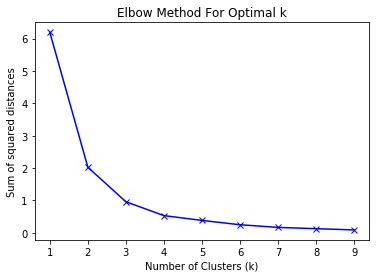

In [24]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pa_movie_cluster)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### Run the model once for all with cluster number as 3


In [25]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pa_movie_cluster)
kmeans.labels_[:] 

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int32)

### Exploring The Results 

In [26]:
pa_movie_final = pd.merge(pa_movie_theatres,pa_cities_indian_new,on='city',how='left',suffixes=('','_y'))

In [27]:
pa_movie_final.insert(0,'Cluster Labels', kmeans.labels_)

In [28]:
pa_movie_final

,Cluster Labels,city,Theatre Counts,percentage_of_indians
0,0,Allentown,3,1.95
1,1,Bensalem,9,4.45
2,0,Blue Bell,2,1.68
3,0,Bridgeville,2,0.83
4,0,Bristol,2,2.21
5,0,Broomall,4,1.03
6,1,Bryn Mawr,7,1.56
7,0,Clifton Heights,3,1.92
8,0,Downingtown,1,0.86
9,1,Easton,6,0.89


In [30]:
pa_movie_final.loc[pa_movie_final['Cluster Labels'] == 0].sort_values(by='pw',ascending=False)

,Cluster Labels,city,Theatre Counts,percentage_of_indians
33,0,Upper Darby,4,4.84
27,0,Norristown,1,2.63
19,0,Lansdale,1,2.35
4,0,Bristol,2,2.21
0,0,Allentown,3,1.95
7,0,Clifton Heights,3,1.92
2,0,Blue Bell,2,1.68
17,0,Horsham,3,1.56
25,0,Murrysville,2,1.40
11,0,Fairless Hills,1,1.28


In [31]:
pa_movie_final.loc[pa_movie_final['Cluster Labels'] == 1].sort_values(by='percentage_of_indians',ascending=False)

,Cluster Labels,city,Theatre Counts,percentage_of_indians
15,1,Hatfield,9,4.81
1,1,Bensalem,9,4.45
18,1,King Of Prussia,7,4.42
32,1,State College,8,3.30
23,1,Monroeville,7,2.48
10,1,Exton,5,1.84
30,1,Reading,8,1.80
31,1,Scranton,9,1.64
6,1,Bryn Mawr,7,1.56
38,1,Whitehall,5,1.47


In [32]:
pa_movie_final.loc[pa_movie_final['Cluster Labels'] == 2].sort_values(by='percentage_of_indians',ascending=False)

,Cluster Labels,city,Theatre Counts,percentage_of_indians
28,2,Philadelphia,8,26.20
29,2,Pittsburgh,5,17.14


##### Create a Scatter plot to visualize the results. Coloured by Cluster Label

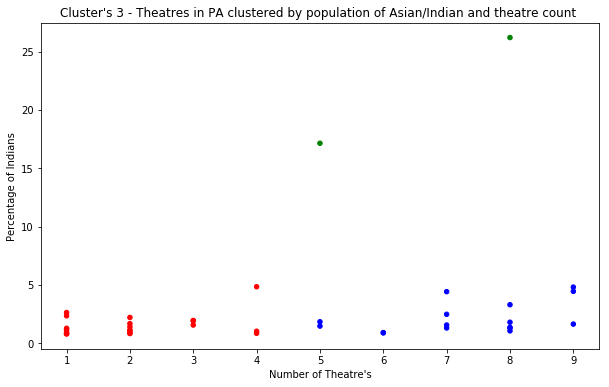

In [35]:
labels=pa_movie_final['Cluster Labels'].astype(str)
label_colour_map = {'0':'r','1':'b','2':'G','3':'k'}
label_color = [label_colour_map[l] for l in labels]

pa_movie_final.plot(kind='scatter', x='Theatre Counts', y='percentage_of_indians', c=label_color, figsize=(10, 6))

plt.title("Cluster's 3 - Theatres in PA clustered by population of Asian/Indian and theatre count ")
plt.xlabel("Number of Theatre's")
plt.ylabel('Percentage of Indians')
plt.show()


### Conclusion - Examining the data points across the clusters gives us an idea of the cities by Indian population and number of theatres available near by. The cities were clusterd predominantly on the theatre count except label 2 is segmented based on population(high) & theatre count (high). In each segment we can segreggate the highest data points (close to percentage of Indians 5) which gives us those cities which have the right proportion of Population by Theatre counts. The cities Philadelphia and Pittsburg are having more Indian population with more number of Theatres available for screening.

